# Proyecto 2 - Inteligencia Artificial

Realizado por: Ana María Garzón y Felipe Muñoz.

Este proyecto se centra en la solución del juego de Buscaminas, haciendo uso de la lógica proposicional y el cálculo de eventos. Del mismo modo, se busca generar un modelo 

In [ ]:
from logica import *
from ec import *
from buscaminas import *
import random as rd
import numpy as np

#Ambiente de desarrollo
El ambiente del programa cuenta con una clase que genera un tablero de buscaminas de un ancho, un largo y una cantidad de minas definidos. Le permite al usuario interactuar para seleccionar casillas y colocar banderas graficando el estado actual del juego, e indica el momento en el que acaba la partida, ya sea porque gana (encontrando todas las minas) o pierde (seleccionando una casilla que tiene una mina).

Además, tiene atributos que permiten obtener las adyacencias de las casillas, los valores (numero de minas adyacentes) y los estados de las casillas (seleccionada, no seleccionada, con bandera...)


# Creación de Base de Conocimiento

## Hechos

Luego de seleccionar una casilla, comienza a construirse una base de conocimiento que incluye los perceptos: casillas abiertas (casillas de las cuales conocemos su valor) y sus respectivos valores y casillas cerradas. Para esto usamos la función $hechos\_global$

In [ ]:
def hechos_global(tab):
  hechos = []
  for casilla in tab.casillas:
    x,y = casilla
    if tab.tablero[x][y].seleccionado and tab.tablero[x][y].valor != 0 and not tab.flags[x][y]:
      hechos += [f'valor_{x},{y}({tab.tablero[x][y].valor})']
    elif not tab.tablero[x][y].seleccionado and tab.tablero[x][y].valor != 0 and not tab.flags[x][y]:
      hechos += [f'no_abierta({x},{y})']
    elif tab.tablero[x][y].seleccionado and tab.tablero[x][y].valor != 0 and tab.flags[x][y]:
      hechos += [f'bandera({x}, {y})']
  return hechos

hechos_tablero = hechos_global(tab)

##Reglas de posicionamiento y selección

Una vez se tienen los hechos (perceptos) los cuales se obtienen de observar el entorno, en este caso, el tablero,es posible definir ciertas reglas que entregan la información necesaria para ganar el juego de manera efectiva. La solución propuesta se centra en dos procesos principales, los cuales permiten construir de manera iterativa las diferentes reglas que permiten obtener las reglas del juego.

A continuación, se definen las funciones buscar_minas y seleccionar_minas para generar las reglas que indican donde colocar las bandera, con el fin de deducir donde estan las minas y que casillas no tienen mina y pueden seleccionarse para continuar el juego de manera segura.


In [ ]:
#FUNCIÓN QUE GENERA LAS REGLAS PARA PONER BANDERAS SEGÚN LAS CASILLAS ABIERTAS

def buscar_minas(tab):
  reglas = []
  for casilla in tab.casillas:
    formula = ''
    ady_no_seleccionadas = []
    cont_sin_flag = 0
    cont_con_flag = 0
    x,y = casilla
    if tab.tablero[x][y].seleccionado and tab.tablero[x][y].valor != 0 and not tab.flags[x][y]:
      #print(casilla, "valor: ",tab.tablero[x][y].valor)
      formula += f'valor_{x},{y}({tab.tablero[x][y].valor})'
      for ady in adyacentes(casilla,8):
        x_ady, y_ady = ady
        if not tab.tablero[x_ady][y_ady].seleccionado:
          #print("Casilla ", x_ady, ",", y_ady, "no seleccionada")
          if not tab.flags[x_ady][y_ady]:
            #print("Casilla ", x_ady, ",", y_ady, "sin bandera")
            ady_no_seleccionadas.append(ady)
            cont_sin_flag += 1
            formula += f'Yno_abierta({x_ady},{y_ady})'
        elif tab.tablero[x_ady][y_ady].seleccionado and tab.flags[x_ady][y_ady]:
          cont_con_flag += 1
          formula += f'Ybandera({x_ady}, {y_ady})'
    if tab.tablero[x][y].valor == cont_sin_flag + cont_con_flag:
      i = 0
      for casilla_peligrosa in ady_no_seleccionadas:
        x_mina, y_mina = casilla_peligrosa
        if i == 0:
          formula+= f'>bandera({x_mina}, {y_mina})'
        else:
          formula+= f'Ybandera({x_mina}, {y_mina})'
        reglas += [formula]
        i +=1
  return reglas

In [ ]:
def seleccionar_casilla(tab): 
  # Si se puede deducir por lo menos una casilla sin minas
  reglas = []
  for casilla in tab.casillas:
    formula = ''
    ady_no_seleccionadas = []
    cont_sin_flag = 0
    cont_con_flag = 0
    x,y = casilla
    
    if tab.tablero[x][y].seleccionado and tab.tablero[x][y].valor != 0 and not tab.flags[x][y]:
      #print(casilla, "valor: ",tab.tablero[x][y].valor)
      formula += f'valor_{x},{y}({tab.tablero[x][y].valor})'
      for ady in adyacentes(casilla,tab.width):
        x_ady, y_ady = ady
        if not tab.tablero[x_ady][y_ady].seleccionado:
          #print("Casilla ", x_ady, ",", y_ady, "no seleccionada")
          if not tab.flags[x_ady][y_ady]:
            #print("Casilla ", x_ady, ",", y_ady, "sin bandera")
            ady_no_seleccionadas.append(ady)
            cont_sin_flag += 1
            formula += f'Yno_abierta({x_ady},{y_ady})'
        elif tab.flags[x_ady][y_ady]:
          cont_con_flag += 1
          formula += f'Ybandera({x_ady}, {y_ady})'
          #print("Casilla ", x_ady, ",", y_ady, "con bandera")
            
    if tab.tablero[x][y].valor == cont_con_flag:
      #print(formula)
      i = 0
      for j in ady_no_seleccionadas:
        x_no_mina, y_no_mina = j
        if i == 0:
          formula+= f'>libre({x_no_mina}, {y_no_mina})'
        else:
          formula+= f'Ylibre({x_no_mina}, {y_no_mina})'
        reglas += [formula]
        i += 1
        #zprint(reglas)
        #tab.transicion(j) # PREGUNTAR

  # Si no se puede deducir una casilla sin minas, se elige una al azar

  return reglas

#Ejemplo

Para comenzar, inicializamos un tablero y seleccionamos la casilla (1,1)

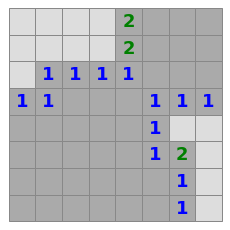

In [ ]:
tab = Buscaminas(8,8,5)
tab.transicion((1,1))
tab.pintar_casilla()

A partir del estado actual del tablero, utilizamos la función buscar_minas para identificar los lugares en los cuales se puede deducir la existencia de minas y generamos las reglas.

In [ ]:
reglas1 = buscar_minas(tab)
for i in reglas1:
  print(i)

valor_0,4(1)Yno_abierta(0,5)>bandera(0, 5)
valor_1,4(1)Yno_abierta(0,5)>bandera(0, 5)
valor_4,5(1)Yno_abierta(3,6)>bandera(3, 6)
valor_4,6(2)Yno_abierta(3,6)Yno_abierta(3,7)>bandera(3, 6)
valor_4,6(2)Yno_abierta(3,6)Yno_abierta(3,7)>bandera(3, 6)Ybandera(3, 7)
valor_4,7(2)Yno_abierta(3,6)Yno_abierta(3,7)>bandera(3, 6)
valor_4,7(2)Yno_abierta(3,6)Yno_abierta(3,7)>bandera(3, 6)Ybandera(3, 7)
valor_5,2(1)Yno_abierta(6,3)>bandera(6, 3)
valor_5,3(1)Yno_abierta(6,3)>bandera(6, 3)
valor_5,4(1)Yno_abierta(6,3)>bandera(6, 3)


Teniendo en cuenta los consecuentes de las reglas generadas, agregamos las banderas correspondientes al tablero de juego

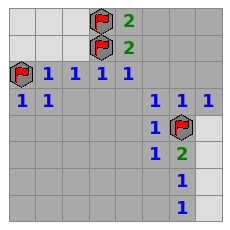

In [ ]:
tab.agregar_quitar_bandera((0,5))
tab.agregar_quitar_bandera((3,6))
tab.agregar_quitar_bandera((3,7))
tab.agregar_quitar_bandera((6,3))
tab.pintar_casilla()

Es evidente que la casilla (2,6) no tiene mina, así que usaremos la funcion seleccionar_casilla para identificar aquellas que deben abrirse para continuar el juego, añadir las reglas a la base de conocimiento y usar la función ASK para verificar que efectivamente, esa casilla sería seleccionada en el próximo turno.


In [ ]:
hechos_tablero =  hechos_global(tab)
reglas1 += seleccionar_casilla(tab)

In [ ]:
BC = LPQuery(reglas1)
for h in hechos_tablero:
      BC.TELL(h)
print(BC)

Datos:
valor_0,4(1)
bandera(0, 5)
no_abierta(0,6)
valor_1,4(1)
valor_1,5(1)
no_abierta(1,6)
valor_2,5(1)
no_abierta(2,6)
no_abierta(2,7)
valor_3,5(1)
bandera(3, 6)
bandera(3, 7)
valor_4,5(1)
valor_4,6(2)
valor_4,7(2)
valor_5,2(1)
valor_5,3(1)
valor_5,4(1)
valor_6,0(1)
valor_6,1(1)
valor_6,2(2)
bandera(6, 3)
valor_6,4(1)
no_abierta(7,0)
no_abierta(7,1)
no_abierta(7,2)
no_abierta(7,3)
valor_7,4(1)

Reglas:
valor_0,4(1)Yno_abierta(0,5)>bandera(0, 5)
valor_1,4(1)Yno_abierta(0,5)>bandera(0, 5)
valor_4,5(1)Yno_abierta(3,6)>bandera(3, 6)
valor_4,6(2)Yno_abierta(3,6)Yno_abierta(3,7)>bandera(3, 6)
valor_4,6(2)Yno_abierta(3,6)Yno_abierta(3,7)>bandera(3, 6)Ybandera(3, 7)
valor_4,7(2)Yno_abierta(3,6)Yno_abierta(3,7)>bandera(3, 6)
valor_4,7(2)Yno_abierta(3,6)Yno_abierta(3,7)>bandera(3, 6)Ybandera(3, 7)
valor_5,2(1)Yno_abierta(6,3)>bandera(6, 3)
valor_5,3(1)Yno_abierta(6,3)>bandera(6, 3)
valor_5,4(1)Yno_abierta(6,3)>bandera(6, 3)
valor_1,5(1)Yno_abierta(2,6)Yno_abierta(0,6)Ybandera(0, 5)Yno_abierta(

In [ ]:
ASK('libre(2, 6)', 'success', BC)

True

# Implementación

Primero, haremos funciones que permiten crear juegos y elegir casillas seguras siempre

In [ ]:
def iniciar_juego_aleatorio(minas):
  tab = Buscaminas(8,8,num_minas=minas)
  tab.transicion((rd.randint(0,tab.width-1),rd.randint(0,tab.height-1)))
  return tab


def iniciar_juego_sin_adivinar(minas):
  tab = Buscaminas(8,8,num_minas=minas)
  for i in tab.casillas:
    x,y = i
    if tab.tablero[x][y].valor == 0:
      tab.transicion((x,y))
      return tab

def elegir_casilla_segura(tab):
  for i in tab.casillas:
    x,y = i
    if tab.tablero[x][y].valor != -1 and not tab.tablero[x][y].seleccionado:
      tab.transicion((x,y))
      break



Ahora, a partir de las funciones que crean el juego y eligen casillas seguras, creamos una función que utiliza la base de conocimiento para deducir la solución del juego.

In [ ]:
#Función que utiliza la base de conocimiento para deducir la solución del juego 

def jugar_2(tab):
  iteraciones = 0
  BC = LPQuery([])
  while tab.juego_activo and iteraciones <= 100:
    #print(BC)
    hechos_BC = hechos_global(tab)
    reglas_minas = buscar_minas(tab)

    for h in hechos_BC:
      BC.TELL(h)

    for r_m in reglas_minas:
      BC.TELL(r_m)

    for casilla in tab.casillas:
      x,y = casilla
      inferencia = ASK(f'bandera({x}, {y})', 'success', BC)
      if inferencia and not tab.flags[x][y]:
        tab.agregar_quitar_bandera((x,y))

    reglas_libres = seleccionar_casilla(tab)
    for r_l in reglas_libres:
      BC.TELL(r_l)

    seleccion = False
    for casilla in tab.casillas:
      x,y = casilla
      inferencia = ASK(f'libre({x}, {y})', 'success', BC)
      if inferencia and not tab.tablero[x][y].seleccionado:
        #print(x,',',y,' seleccionado')
        seleccion = True
        tab.transicion((x,y))
    if not seleccion:
      #print("Al azar")
      elegir_casilla_segura(tab)

    iteraciones += 1
    #tab.pintar_casilla()
  #print(BC)

Ahora, mostraremos el funcionamiento de la función

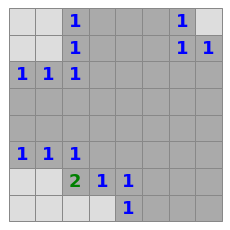

In [ ]:
tab = iniciar_juego_aleatorio(4)
tab.pintar_casilla()

In [ ]:
jugar_2(tab)

1


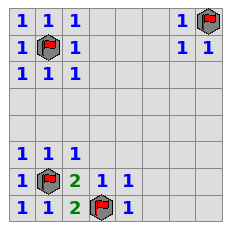

In [ ]:
tab.pintar_todo()
print(tab.ganar)

In [ ]:
jugar_2(tab)

# Evaluación

Finalmente, evaluaremos el desempeño de la implementación de la solución ejecutando 100 veces juegos que tienen de 5 a 12 minas; sacando el porcentaje de error.

In [ ]:
total_juegos = 100
for i in range(5,13):
    juegos_perdidos = 0
    for j in range(total_juegos):
        tab = iniciar_juego_sin_adivinar(i)
        jugar_2(tab)
        if tab.ganar == -1:
            juegos_perdidos += 1    
    print("Porcentaje de juegos perdidos con ",i," minas: ",(juegos_perdidos/total_juegos)*100, "%")

Porcentaje de juegos perdidos con  5  minas:  8.0 %
Porcentaje de juegos perdidos con  6  minas:  12.0 %
Porcentaje de juegos perdidos con  7  minas:  8.0 %
Porcentaje de juegos perdidos con  8  minas:  13.0 %
Porcentaje de juegos perdidos con  9  minas:  15.0 %
Porcentaje de juegos perdidos con  10  minas:  9.0 %
Porcentaje de juegos perdidos con  11  minas:  6.0 %
Porcentaje de juegos perdidos con  12  minas:  6.0 %
